In [87]:
import os
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
#os.environ["CUDA_VISIBLE_DEVICES"]="0";
from __future__ import print_function, division
from builtins import range, input
# Note: you may need to update your version of future
# sudo pip install -U future
import theano

from keras.layers import Input, Lambda, Dense, Flatten
from keras import optimizers
from keras.models import Model
from keras.applications.resnet50 import ResNet50, preprocess_input
# from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
print(tf.__version__)
from glob import glob

import warnings
warnings.filterwarnings('ignore')

1.14.0


In [88]:
#Device mapping:
#/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
#/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
#sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6463119035499761370
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 10817388667950378945
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 9875398722914402788
physical_device_desc: "device: XLA_CPU device"
]


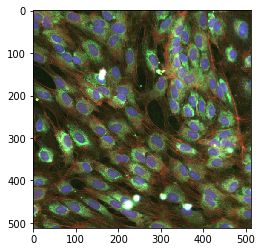

In [90]:
# re-size all the images to this
IMAGE_SIZE = [224, 224] # feel free to change depending on dataset

# training config:
epochs = 4
batch_size = 16

train_path = '../input/train'
valid_path = '../input/test'

# useful for getting number of files
image_files = glob(train_path + '/*/*.png')
valid_image_files = glob(valid_path + '/*/*.png')

# useful for getting number of classes
folders = glob(train_path + '/*')

# look at an image for fun
plt.imshow(image.load_img(np.random.choice(image_files)))
plt.show()

In [91]:
# add preprocessing layer to the front of VGG
res = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train existing weights
for layer in res.layers:
  layer.trainable = False

In [92]:
# our layers - you can add more if you want
x = Flatten()(res.output)
x = Dense(1108, activation='relu')(x)
x = Dense(1108, activation='relu')(x)

prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=res.input, outputs=prediction)

# view the structure of the model
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_9[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [120]:
def random_crop(img, random_crop_size):
    # Note: image_data_format is 'channel_last'
    assert img.shape[2] == 3
    height, width = img.shape[0], img.shape[1]
    dy, dx = random_crop_size
    x = np.random.randint(0, width - dx + 1)
    y = np.random.randint(0, height - dy + 1)
    return img[y:(y+dy), x:(x+dx), :]


def crop_generator(batches, crop_length):
    """Take as input a Keras ImageGen (Iterator) and generate random
    crops from the image batches generated by the original iterator.
    """
    while True:
        batch_x, batch_y = next(batches)
        batch_crops = np.zeros((batch_x.shape[0], crop_length, crop_length, 3))
        for i in range(batch_x.shape[0]):
            batch_crops[i] = random_crop(batch_x[i], (crop_length, crop_length))
        yield (batch_crops, batch_y)

In [151]:
learning_rate = 0.05
decay_rate = learning_rate / epochs
opt = optimizers.RMSprop(lr=learning_rate, decay=decay_rate)

# tell the model what cost and optimization method to use
model.compile(
    optimizer=opt, 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

# create an instance of ImageDataGenerator
gen = ImageDataGenerator(
  rotation_range=20,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.1,
  zoom_range=0.2,
  horizontal_flip=True,
  vertical_flip=True,
  preprocessing_function=preprocess_input
)

Found 8800 images belonging to 1108 classes.
{'475': 526, '192': 212, '917': 1017, '885': 981, '497': 550, '596': 660, '703': 780, '397': 439, '887': 983, '275': 304, '508': 563, '355': 393, '220': 244, '607': 673, '1058': 67, '335': 371, '966': 1071, '665': 737, '933': 1035, '778': 862, '288': 318, '688': 762, '890': 987, '471': 522, '530': 588, '403': 447, '1055': 64, '295': 326, '831': 922, '37': 409, '1020': 26, '1071': 82, '1045': 53, '973': 1079, '435': 482, '1016': 21, '84': 931, '119': 131, '121': 134, '260': 288, '595': 659, '179': 197, '1086': 98, '797': 883, '862': 956, '951': 1055, '467': 517, '271': 300, '868': 962, '100': 3, '305': 338, '1040': 48, '500': 555, '103': 36, '791': 877, '875': 970, '86': 953, '107': 80, '1024': 30, '196': 216, '153': 169, '856': 949, '789': 874, '921': 1022, '838': 929, '574': 636, '109': 102, '635': 704, '1060': 70, '1052': 61, '1006': 10, '937': 1039, '1097': 110, '339': 375, '845': 937, '278': 307, '824': 914, '1027': 33, '543': 602, '539'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


min: -115.44661 max: 151.061


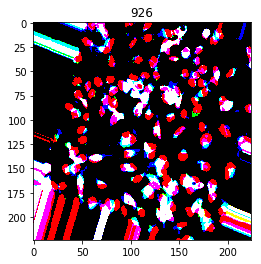

In [152]:
# test generator to see how it works and some other useful things

# get label mapping for confusion matrix plot later
test_gen = gen.flow_from_directory(valid_path, target_size=IMAGE_SIZE)
print(test_gen.class_indices)
labels = [None] * len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
  labels[v] = k

# should be a strangely colored image (due to VGG weights being BGR)
for x, y in test_gen:
  print("min:", x[0].min(), "max:", x[0].max())
  plt.title(labels[np.argmax(y[0])])
  plt.imshow(x[0])
  plt.show()
  break

In [153]:
# create generators
train_generator = gen.flow_from_directory(
  train_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)
valid_generator = gen.flow_from_directory(
  valid_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)

Found 19932 images belonging to 1108 classes.
Found 8800 images belonging to 1108 classes.


In [154]:
checkpoint_path = "training1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [155]:
class LearningRateScheduler(tf.keras.callbacks.Callback):
  """Learning rate scheduler which sets the learning rate according to schedule.

  Arguments:
      schedule: a function that takes an epoch index
          (integer, indexed from 0) and current learning rate
          as inputs and returns a new learning rate as output (float).
  """

  def __init__(self, schedule):
    super(LearningRateScheduler, self).__init__()
    self.schedule = schedule

  def on_epoch_begin(self, epoch, logs=None):
    if not hasattr(self.model.optimizer, 'lr'):
      raise ValueError('Optimizer must have a "lr" attribute.')
    # Get the current learning rate from model's optimizer.
    lr = float(tf.keras.backend.get_value(self.model.optimizer.lr))
    # Call schedule function to get the scheduled learning rate.
    scheduled_lr = self.schedule(epoch, lr)
    # Set the value back to the optimizer before this epoch starts
    tf.keras.backend.set_value(self.model.optimizer.lr, scheduled_lr)
    print('\nEpoch %05d: Learning rate is %6.4f.' % (epoch, scheduled_lr))

In [156]:
LR_SCHEDULE = [
    # (epoch to start, learning rate) tuples
    (0, 0.05), (2, 0.01), (5, 0.005), (10, 0.001)
]

def lr_schedule(epoch, lr):
  """Helper function to retrieve the scheduled learning rate based on epoch."""
  LR_SCHEDULE = [   (0, 0.05), (2, 0.01), (5, 0.005), (10, 0.001)]
  if epoch < LR_SCHEDULE[0][0] or epoch > LR_SCHEDULE[-1][0]:
    return lr
  for i in range(len(LR_SCHEDULE)):
    if epoch == LR_SCHEDULE[i][0]:
      return LR_SCHEDULE[i][1]
  return lr


In [157]:
class LossAndErrorPrintingCallback(tf.keras.callbacks.Callback):

  def on_train_batch_end(self, batch, logs=None):
    print('For batch {}, loss is {:7.2f}.'.format(batch, logs['loss']))

  def on_test_batch_end(self, batch, logs=None):
    print('For batch {}, loss is {:7.2f}.'.format(batch, logs['loss']))

  def on_epoch_end(self, epoch, logs=None):
    print('The average loss for epoch {} is {:7.2f}.'.format(epoch, logs['loss']))


In [158]:
model.load_weights(checkpoint_path)

In [159]:
train_generator = crop_generator(train_generator, 224)
valid_generator = crop_generator(valid_generator, 224)

# fit the model
with tf.device('/gpu:0'):

    r = model.fit_generator(
      train_generator,
      validation_data=valid_generator,
      initial_epoch=3,  
      epochs=5,
      steps_per_epoch=len(image_files) // batch_size,
      validation_steps=len(valid_image_files) // batch_size,
     callbacks = [cp_callback, LossAndErrorPrintingCallback()]
    )

Epoch 4/5
1245/1245 [==============================] - 3316s 3s/step - loss: 16.1035 - acc: 9.0361e-04 - val_loss: 16.1034 - val_acc: 9.0909e-04

Epoch 00004: saving model to training1/cp.ckpt
The average loss for epoch 3 is   16.10.
Epoch 5/5
 449/1245 [=========>....................] - ETA: 22:41 - loss: 16.1001 - acc: 0.0011

KeyboardInterrupt: 